### Fraud_Detection on Transactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv("fraud_detection.csv")
display(data.head())

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   277  CASH_OUT   135823.38  C1593233399      143871.00         8047.62   
1   207  CASH_OUT   288639.74   C798341710         584.00            0.00   
2   196  TRANSFER   553399.25  C1967632347      553399.25            0.00   
3    79  TRANSFER  1619331.51   C144675030     1619331.51            0.00   
4   251  CASH_OUT   254768.53  C2070917948        5142.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C1539414805      3200782.20      3336605.59        0               0  
1  C1082976131      3005558.14      3294197.88        0               0  
2  C1971557254            0.00            0.00        1               0  
3   C660991644            0.00            0.00        1               0  
4  C1290691221       103461.62       358230.15        0               0

## Normalizing the Dataset

In [3]:
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [4]:
def create_schema_and_load_data(conn, data_file):
    # Create tables
    transaction_types_sql = """
    CREATE TABLE IF NOT EXISTS transaction_types (
        type_id INTEGER PRIMARY KEY AUTOINCREMENT,
        type_name TEXT NOT NULL UNIQUE
    );"""
    
    accounts_sql = """
    CREATE TABLE IF NOT EXISTS accounts (
        account_id TEXT PRIMARY KEY,
        current_balance REAL DEFAULT 0.0
    );"""
    
    transactions_sql = """
    CREATE TABLE IF NOT EXISTS transactions (
        transaction_id INTEGER PRIMARY KEY,
        step INTEGER NOT NULL,
        type_id INTEGER,
        amount REAL NOT NULL,
        origin_account TEXT,
        destination_account TEXT,
        is_fraud INTEGER CHECK (is_fraud IN (0, 1)),
        is_flagged_fraud INTEGER CHECK (is_flagged_fraud IN (0, 1)),
        FOREIGN KEY (type_id) REFERENCES transaction_types(type_id),
        FOREIGN KEY (origin_account) REFERENCES accounts(account_id),
        FOREIGN KEY (destination_account) REFERENCES accounts(account_id)
    );"""
    
    balance_history_sql = """
    CREATE TABLE IF NOT EXISTS balance_history (
        balance_id INTEGER PRIMARY KEY AUTOINCREMENT,
        account_id TEXT,
        transaction_id INTEGER,
        old_balance REAL,
        new_balance REAL,
        is_destination INTEGER CHECK (is_destination IN (0, 1)),
        FOREIGN KEY (account_id) REFERENCES accounts(account_id),
        FOREIGN KEY (transaction_id) REFERENCES transactions(transaction_id)
    );"""
    
    # Create all tables
    create_table(conn, transaction_types_sql)
    create_table(conn, accounts_sql)
    create_table(conn, transactions_sql)
    create_table(conn, balance_history_sql)
    
    cursor = conn.cursor()
    
    # First, insert transaction types and store their IDs
    transaction_types = {
        'CASH_OUT': None,
        'CASH_IN': None,
        'TRANSFER': None,
        'PAYMENT': None
    }
    
    # Insert transaction types and get their IDs
    for type_name in transaction_types.keys():
        cursor.execute("INSERT OR IGNORE INTO transaction_types (type_name) VALUES (?)", (type_name,))
        cursor.execute("SELECT type_id FROM transaction_types WHERE type_name = ?", (type_name,))
        transaction_types[type_name] = cursor.fetchone()[0]
    
    conn.commit()
    
    # Read and process the data file
    with open(data_file, 'r') as f:
        # Skip header if it exists
        header = f.readline()
        
        for line in f:
            try:
                # Parse the CSV line
                fields = [field.strip() for field in line.strip().split(',')]
                if len(fields) != 11:  # Validate number of fields
                    print(f"Skipping invalid line: {line}")
                    continue
                
                step = int(fields[0])
                type_name = fields[1].strip()
                amount = float(fields[2])
                origin_account = fields[3]
                origin_old_balance = float(fields[4])
                origin_new_balance = float(fields[5])
                dest_account = fields[6]
                dest_old_balance = float(fields[7])
                dest_new_balance = float(fields[8])
                is_fraud = int(fields[9])
                is_flagged_fraud = int(fields[10])
                
                # Get type_id from our dictionary
                type_id = transaction_types.get(type_name)
                if type_id is None:
                    continue
                
                # Insert accounts if they don't exist
                cursor.execute("INSERT OR IGNORE INTO accounts (account_id) VALUES (?)", (origin_account,))
                if dest_account.startswith(('C', 'M')):  # Valid account
                    cursor.execute("INSERT OR IGNORE INTO accounts (account_id) VALUES (?)", (dest_account,))
                
                # Insert transaction
                cursor.execute("""
                    INSERT INTO transactions 
                    (step, type_id, amount, origin_account, destination_account, is_fraud, is_flagged_fraud)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (step, type_id, amount, origin_account, dest_account, is_fraud, is_flagged_fraud))
                
                transaction_id = cursor.lastrowid
                
                # Insert balance history for origin account
                cursor.execute("""
                    INSERT INTO balance_history 
                    (account_id, transaction_id, old_balance, new_balance, is_destination)
                    VALUES (?, ?, ?, ?, 0)
                """, (origin_account, transaction_id, origin_old_balance, origin_new_balance))
                
                # Insert balance history for destination account
                if dest_account.startswith(('C', 'M')):  # Valid account
                    cursor.execute("""
                        INSERT INTO balance_history 
                        (account_id, transaction_id, old_balance, new_balance, is_destination)
                        VALUES (?, ?, ?, ?, 1)
                    """, (dest_account, transaction_id, dest_old_balance, dest_new_balance))
                
                # Update current balances
                cursor.execute("UPDATE accounts SET current_balance = ? WHERE account_id = ?", 
                             (origin_new_balance, origin_account))
                if dest_account.startswith(('C', 'M')):
                    cursor.execute("UPDATE accounts SET current_balance = ? WHERE account_id = ?", 
                                 (dest_new_balance, dest_account))
                
                if (cursor.rowcount % 1000) == 0:
                    conn.commit()
                    
            except Exception as e:
                print(f"Error processing line: {line}")
                print(f"Error details: {str(e)}")
                continue
    
    conn.commit()
    print("Data loading completed successfully!")

In [5]:
conn = create_connection("fraud_detection.db", delete_db=True)
create_schema_and_load_data(conn, "fraud_detection.csv")

Data loading completed successfully!


In [6]:
import pandas as pd

def fetch_fraud_data(conn):
    """
    Fetch fraud detection data from normalized database tables and return as a pandas DataFrame.
    
    Args:
        conn: SQLite database connection
        
    Returns:
        pandas.DataFrame: Combined fraud detection data
    """
    
    query = """
    SELECT 
        t.step,
        tt.type_name as type,
        t.amount,
        t.origin_account as nameOrig,
        orig_bal.old_balance as oldbalanceOrg,
        orig_bal.new_balance as newbalanceOrig,
        t.destination_account as nameDest,
        dest_bal.old_balance as oldbalanceDest,
        dest_bal.new_balance as newbalanceDest,
        t.is_fraud as isFraud,
        t.is_flagged_fraud as isFlaggedFraud
    FROM transactions t
    JOIN transaction_types tt ON t.type_id = tt.type_id
    JOIN balance_history orig_bal ON t.transaction_id = orig_bal.transaction_id 
        AND t.origin_account = orig_bal.account_id 
        AND orig_bal.is_destination = 0
    LEFT JOIN balance_history dest_bal ON t.transaction_id = dest_bal.transaction_id 
        AND t.destination_account = dest_bal.account_id 
        AND dest_bal.is_destination = 1
    ORDER BY t.step;
    """
    
    # Read directly into pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Fill any NULL values in balance columns with 0.0
    balance_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    df[balance_cols] = df[balance_cols].fillna(0.0)
    
    return df

conn = create_connection("fraud_detection.db")
df = fetch_fraud_data(conn)
display(df)

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1  CASH_OUT   132842.64    C13692003        4499.08            0.00   
1         1  TRANSFER      181.00  C1305486145         181.00            0.00   
2         1  CASH_OUT   416001.33   C749981943           0.00            0.00   
3         1   PAYMENT     1915.43   C822087264       11450.00         9534.57   
4         1  CASH_OUT      181.00   C840083671         181.00            0.00   
...     ...       ...         ...          ...            ...             ...   
24510   743  TRANSFER  6311409.28  C1529008245     6311409.28            0.00   
24511   743  CASH_OUT  6311409.28  C1162922333     6311409.28            0.00   
24512   743  TRANSFER   850002.52  C1685995037      850002.52            0.00   
24513   743  CASH_OUT   850002.52  C1280323807      850002.52            0.00   
24514   743  CASH_OUT   339682.13   C786484425      339682.13            0.00   

          nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0       C297927961            0.00       132842.64        1               0  
1       C553264065            0.00            0.00        1               0  
2       C667346055          102.00      9291619.62        1               0  
3        M30699728            0.00            0.00        0               0  
4        C38997010        21182.00            0.00        1               0  
...            ...             ...             ...      ...             ...  
24510  C1881841831            0.00            0.00        1               0  
24511  C1365125890        68488.84      6379898.11        1               0  
24512  C2080388513            0.00            0.00        1               0  
24513   C873221189      6510099.11      7360101.63        1               0  
24514   C776919290            0.00       339682.13        1               0  

[24515 rows x 11 columns]

Dataset Shape: (24515, 11)

Data Types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Basic Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  24515.000000  2.451500e+04   2.451500e+04    2.451500e+04   
mean     285.437569  6.152231e+05   1.101861e+06    6.289189e+05   
std      181.064011  1.617177e+06   3.137237e+06    2.647180e+06   
min        1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%      159.000000  2.399208e+04   5.725000e+02    0.000000e+00   
50%      265.000000  1.333361e+05   5.651100e+04    0.000000e+00   
75%      380.500000  3.582903e+05   4.975262e+05    2.193430e+04   
max      743.000000  3.188675e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newba

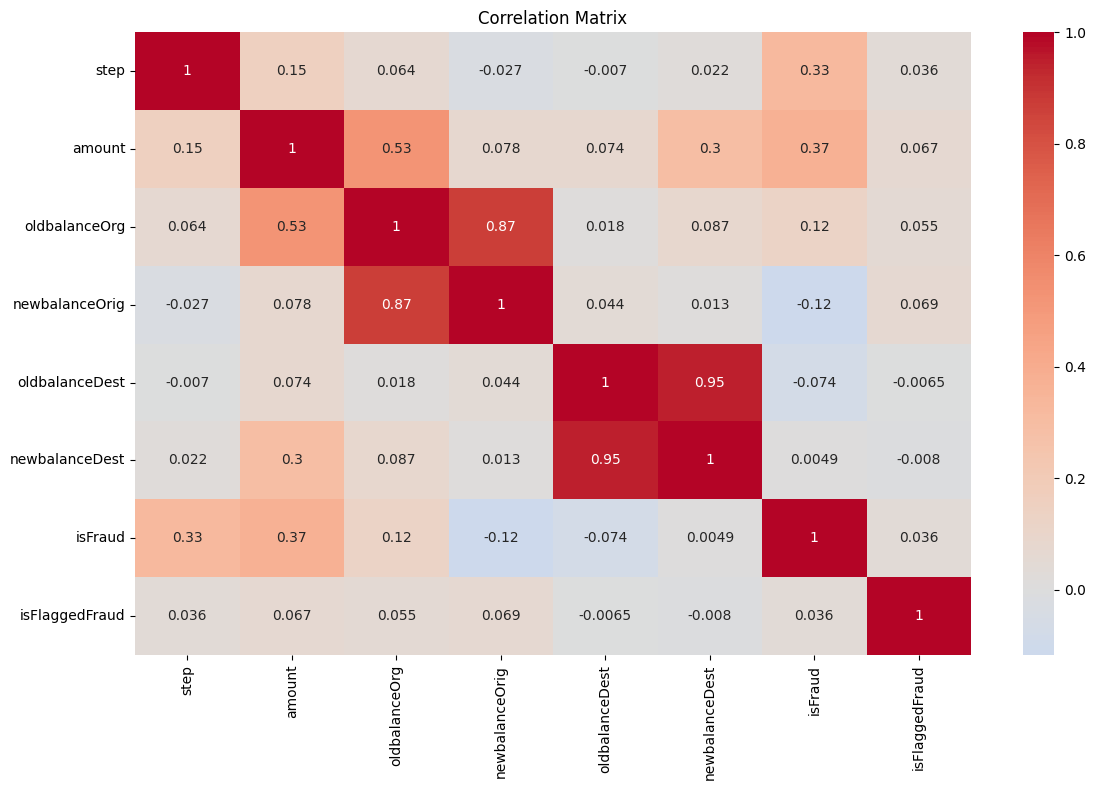

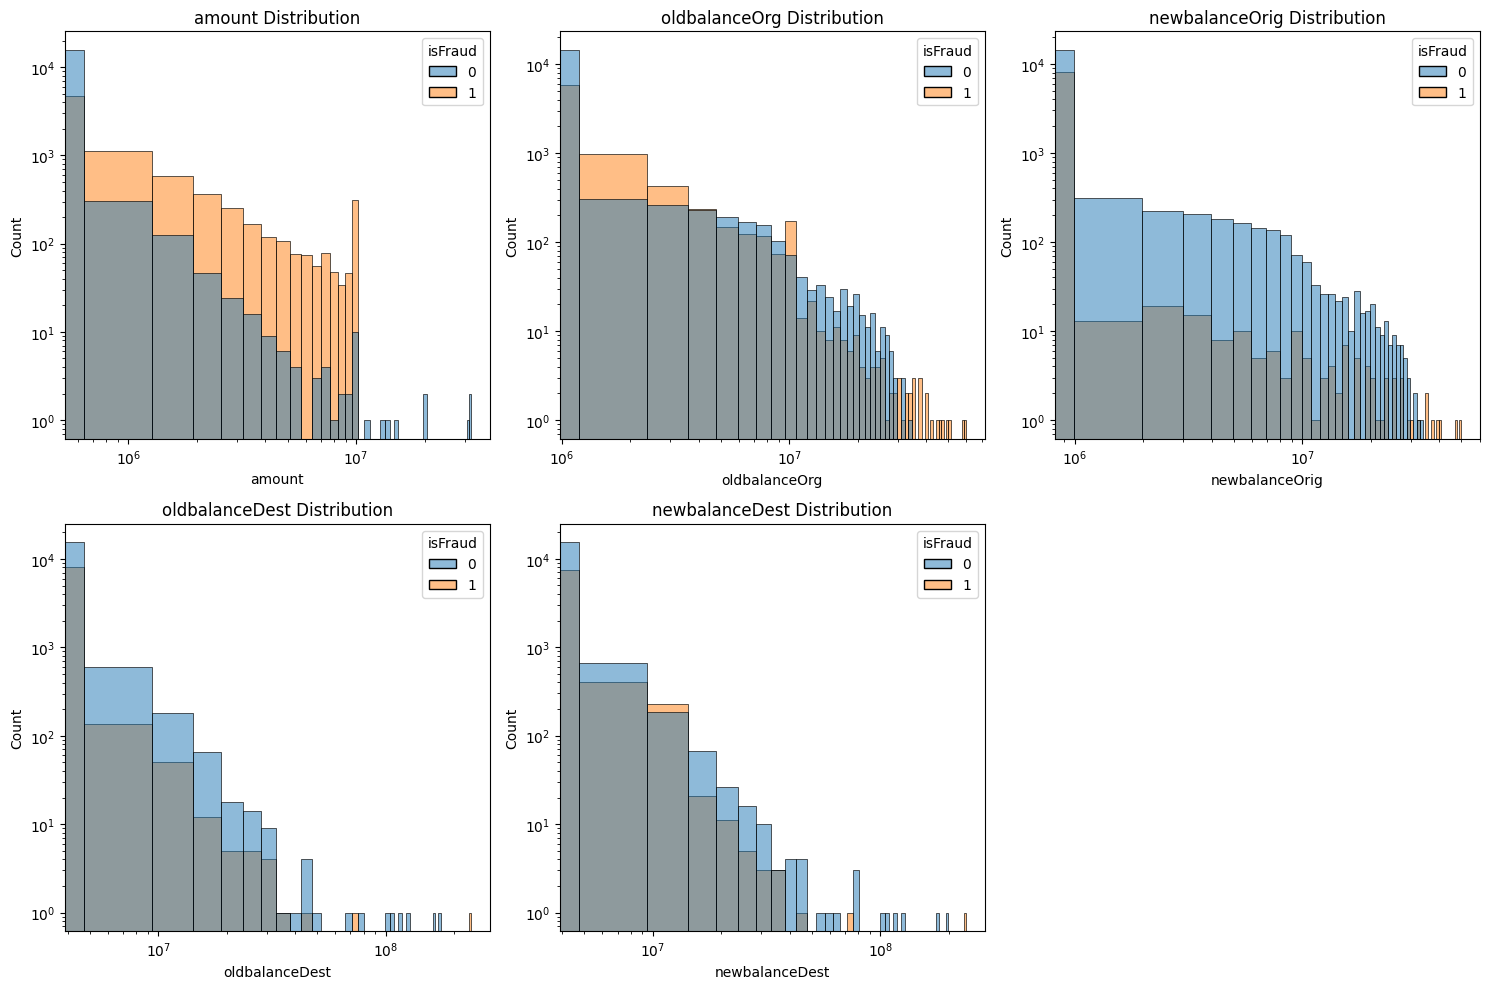

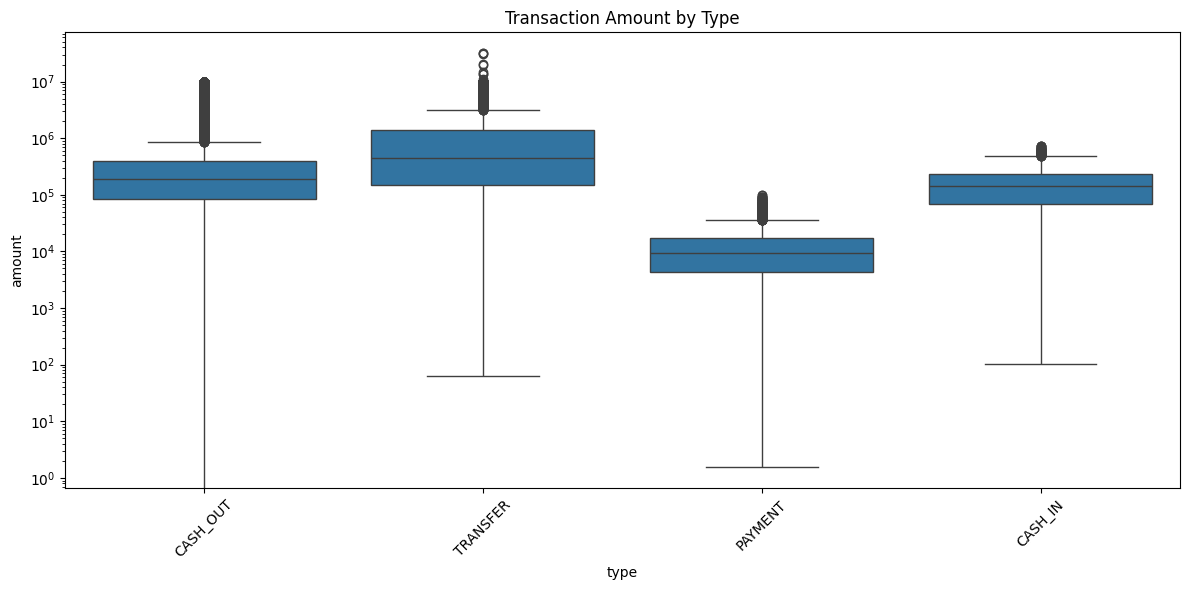


Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Zero Values Count:
amount               16
oldbalanceOrg      5463
newbalanceOrig    17323
oldbalanceDest    12299
newbalanceDest    10400
dtype: int64

Potential Anomalies:

amount:
Number of outliers: 3376
Min: 0.0
Max: 31886745.04

oldbalanceOrg:
Number of outliers: 4146
Min: 0.0
Max: 59585040.37

newbalanceOrig:
Number of outliers: 5355
Min: 0.0
Max: 49585040.37

oldbalanceDest:
Number of outliers: 3396
Min: 0.0
Max: 236230516.82

newbalanceDest:
Number of outliers: 2958
Min: 0.0
Max: 236726494.66

Stratification Analysis:

Class Distribution:
isFraud
0    0.664981
1    0.335019
Name: proportion, dtype: float64

Fraud Rate by Transaction Type:
          count      mean
type                     
CASH_IN    3582  0.000000
CASH_OUT   9920

/var/folders/st/ypkxfxmd1j9br2vhgr1pbdch0000gn/T/ipykernel_25004/780226841.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('amount_quartile')['isFraud'].mean())


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def explore_fraud_data(conn):
    """
    Comprehensive exploration of fraud detection dataset
    """
    # Fetch data
    df = fetch_fraud_data(conn)
    
    print("Dataset Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe())
    
    # Class distribution
    print("\nFraud Distribution:")
    print(df['isFraud'].value_counts(normalize=True))
    
    # Distribution by transaction type
    fraud_by_type = pd.crosstab(df['type'], df['isFraud'], normalize='index')
    print("\nFraud Rate by Transaction Type:")
    print(fraud_by_type)
    
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Distribution plots for numeric features
    numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest']
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df, x=feature, hue='isFraud', bins=50, alpha=0.5)
        plt.title(f'{feature} Distribution')
        plt.yscale('log')
        plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    # Box plots for amount by transaction type
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='type', y='amount')
    plt.xticks(rotation=45)
    plt.title('Transaction Amount by Type')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Check for zero values
    print("\nZero Values Count:")
    zero_counts = (df[numeric_features] == 0).sum()
    print(zero_counts)
    
    # Analyze potential anomalies
    print("\nPotential Anomalies:")
    for col in numeric_features:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = df[col][(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))]
        print(f"\n{col}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Min: {df[col].min()}")
        print(f"Max: {df[col].max()}")
    
    return {
        'df': df,
        'fraud_rate': df['isFraud'].mean(),
        'fraud_by_type': fraud_by_type,
        'correlation': correlation
    }

def stratification_analysis(df):
    """
    Analyze whether stratification is needed and by which variables
    """
    print("\nStratification Analysis:")
    
    # Check class imbalance
    print("\nClass Distribution:")
    print(df['isFraud'].value_counts(normalize=True))
    
    # Check fraud rate by transaction type
    print("\nFraud Rate by Transaction Type:")
    fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'mean'])
    print(fraud_by_type)
    
    # Chi-square test for independence between type and fraud
    contingency = pd.crosstab(df['type'], df['isFraud'])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]
    print(f"\nChi-square test p-value: {p_value}")
    
    # Amount quartiles analysis
    df['amount_quartile'] = pd.qcut(df['amount'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    print("\nFraud Rate by Amount Quartile:")
    print(df.groupby('amount_quartile')['isFraud'].mean())
    
    return {
        'chi2_p_value': p_value,
        'fraud_by_type': fraud_by_type
    }

def create_cleanup_tasks(df):
    """
    Create list of data cleanup tasks based on exploration
    """
    cleanup_tasks = []
    
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        cleanup_tasks.append("Handle missing values")
    
    # Check for zero values in important columns
    zero_values = (df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                      'oldbalanceDest', 'newbalanceDest']] == 0).sum()
    if zero_values.sum() > 0:
        cleanup_tasks.append("Investigate zero values in numeric columns")
    
    # Check for negative values
    neg_values = (df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest']] < 0).sum()
    if neg_values.sum() > 0:
        cleanup_tasks.append("Handle negative values")
    
    # Check balance consistency
    balance_mismatch = df[df['oldbalanceOrg'] < df['newbalanceOrig']]
    if len(balance_mismatch) > 0:
        cleanup_tasks.append("Investigate balance inconsistencies")
    
    # Check for extreme values
    for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = df[col][(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))]
        if len(outliers) > 0:
            cleanup_tasks.append(f"Handle outliers in {col}")
    
    return cleanup_tasks

conn = create_connection("fraud_detection.db")
results = explore_fraud_data(conn)
strat_results = stratification_analysis(results['df'])
cleanup_tasks = create_cleanup_tasks(results['df'])

print("\nRecommended Data Cleanup Tasks:")
for i, task in enumerate(cleanup_tasks, 1):
    print(f"{i}. {task}")

In [8]:
from ydata_profiling import ProfileReport

# Generate the profile report
profile = ProfileReport(data, title="Data Profiling Report", explorative=True)

# Save the report as an HTML file
profile.to_file("data_profiling_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Observations from Exploratory Data Analysis (EDA):
1. General Data Overview:

The dataset contains multiple features related to transactions, such as amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest.
There is a binary target variable isFraud indicating whether a transaction is fraudulent.

2. Distribution of isFraud:

The dataset is highly imbalanced, with fraudulent transactions making up a small percentage of the total data. This indicates the need for resampling techniques or stratification during model training.

3. Transaction Type Analysis:

Certain transaction types (TRANSFER and CASH_OUT) have higher fraud rates compared to others (PAYMENT, DEBIT, and CASH_IN).
TRANSFER and CASH_OUT transactions likely involve significant amounts, making them a common target for fraudulent activities.

4. Correlation Matrix Insights:

High correlation between oldbalanceOrg and newbalanceOrig indicates that the balances are closely linked, which aligns with the nature of balance updates during transactions.
Low correlation between amount and other features suggests that the transaction amount varies independently of other balance-related features.

5. Numeric Feature Distributions:

The distribution of amount and balance features (oldbalanceOrg, newbalanceOrig, etc.) is heavily skewed, with a few large transactions creating long tails.
Log scaling the distributions reveals clearer patterns and reduces skewness, improving visibility into smaller transactions.

6. Capped Values and Anomalies:

Some features show potential capping at certain values, indicating system-imposed limits. These capped values may obscure genuine patterns and need closer examination.
Outliers are present in transaction amounts and balances, with extreme values possibly representing fraudulent activities or system errors.


## Logistic Regression

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mlflow
from mlflow.models import infer_signature  # Added this import
import os
import warnings
warnings.filterwarnings('ignore')

# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/charankonduru2003/fraud_detection.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'charankonduru2003'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0b22e21e2cfc7080ebc0fc65157efbff55fc501e'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("fraud_detection_experiment")

def log_transform(X):
    """Apply log transformation to numeric data, handling zeros and negative values"""
    return np.log1p(np.abs(X))

def prepare_data(df):
    # Separate features and target
    X = df.drop(['isFlaggedFraud', 'isFraud'], axis=1)
    y = df['isFraud']
    
    # Split categorical and numerical columns
    categorical_cols = ['type', 'nameOrig', 'nameDest']
    numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest', 'step']
    
    return X, y, categorical_cols, numerical_cols

def create_preprocessing(numerical_cols, categorical_cols):
    # Numerical preprocessing pipeline
    numerical_pipeline = Pipeline([
        ('log_transform', FunctionTransformer(log_transform)),
        ('scaler', StandardScaler()),
        ('minmax', MinMaxScaler())
    ])
    
    # Categorical preprocessing pipeline
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ])
    
    return preprocessor

def log_metrics(metrics_dict, prefix=""):
    """Helper function to log metrics to MLflow"""
    for metric_name, metric_value in metrics_dict.items():
        mlflow.log_metric(f"{prefix}{metric_name}", metric_value)

def evaluate_model(model, X, y):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    metrics = {
        'f1_score': f1,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn
    }
    return metrics

def train_and_evaluate(df, n_cv_folds=3):
    with mlflow.start_run(run_name="fraud_detection_experiment"):
        # Prepare data
        X, y, categorical_cols, numerical_cols = prepare_data(df)
        
        # Create and log preprocessing steps
        preprocessor = create_preprocessing(numerical_cols, categorical_cols)
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000))
        ])
        
        # Log pipeline parameters
        mlflow.log_param("n_cv_folds", n_cv_folds)
        mlflow.log_param("model_type", "LogisticRegression")
        
        # Perform cross-validation
        cv = KFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
        
        # Log cross-validation results
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        
        # Hyperparameter tuning
        param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
        
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=3,
            scoring='f1',
            n_jobs=-1
        )
        
        # Fit grid search
        grid_search.fit(X, y)
        
        # Log best parameters
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_cv_f1", grid_search.best_score_)
        
        # Evaluate on full training set
        best_model = grid_search.best_estimator_
        train_metrics = evaluate_model(best_model, X, y)
        log_metrics(train_metrics, "train_")
        
        # Log the model
        signature = infer_signature(X, y)
        mlflow.sklearn.log_model(best_model, "model", signature=signature)
        
        return {
            'cv_scores': cv_scores,
            'best_model': best_model,
            'best_params': grid_search.best_params_,
            'train_metrics': train_metrics
        }

# Run the pipeline with the existing DataFrame
results = train_and_evaluate(data)  # Changed df to data to match your variable name

# Print results
print("\nCross-validation Results:")
print(f"F1 Scores: {results['cv_scores']}")
print(f"Mean F1: {results['cv_scores'].mean():.3f} (±{results['cv_scores'].std():.3f})")

print("\nBest Hyperparameters:")
print(results['best_params'])

print("\nTraining Set Metrics:")
for metric_name, metric_value in results['train_metrics'].items():
    print(f"{metric_name}: {metric_value}")

🏃 View run fraud_detection_experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/6609795d9f2d44e284baadc26f0b28ad
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3


KeyboardInterrupt: 

## Ridge Classifier and Random Forest

In [19]:
from sklearn.linear_model import RidgeClassifier

# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/charankonduru2003/fraud_detection.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'charankonduru2003'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0b22e21e2cfc7080ebc0fc65157efbff55fc501e'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("fraud_detection_experiment")

def prepare_data(df):
    # Separate features and target
    X = df.drop(['isFlaggedFraud', 'isFraud'], axis=1)
    y = df['isFraud']
    
    categorical_cols = ['type', 'nameOrig', 'nameDest']
    numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest', 'step']
    
    return X, y, categorical_cols, numerical_cols

def create_preprocessing(numerical_cols, categorical_cols):
    numerical_pipeline = Pipeline([
        ('log_transform', FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
        ('scaler', StandardScaler()),
        ('minmax', MinMaxScaler())
    ])
    
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ])
    
    return preprocessor

def evaluate_model(model, X, y):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    metrics = {
        'f1_score': f1,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn
    }
    return metrics

def get_classifiers():
    """Return dictionary of classifiers with their default parameters"""
    return {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RidgeClassifier': RidgeClassifier(),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

def train_and_evaluate_models(df, n_cv_folds=3):
    # Prepare data
    X, y, categorical_cols, numerical_cols = prepare_data(df)
    
    # Create preprocessor
    preprocessor = create_preprocessing(numerical_cols, categorical_cols)
    
    # Get classifiers
    classifiers = get_classifiers()
    results = {}
    
    # Train and evaluate each classifier
    for clf_name, classifier in classifiers.items():
        with mlflow.start_run(run_name=f"fraud_detection_{clf_name}"):
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', classifier)
            ])
            
            # Log basic parameters
            mlflow.log_param("model_type", clf_name)
            mlflow.log_param("n_cv_folds", n_cv_folds)
            
            # Perform cross-validation
            cv = KFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
            cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
            
            # Log cross-validation results
            mlflow.log_metric("cv_f1_mean", cv_scores.mean())
            mlflow.log_metric("cv_f1_std", cv_scores.std())
            
            # Fit on full training data
            pipeline.fit(X, y)
            
            # Evaluate on full training set
            train_metrics = evaluate_model(pipeline, X, y)
            for metric_name, metric_value in train_metrics.items():
                mlflow.log_metric(f"train_{metric_name}", metric_value)
            
            # Log the model
            signature = infer_signature(X, y)
            mlflow.sklearn.log_model(pipeline, "model", signature=signature)
            
            # Store results
            results[clf_name] = {
                'cv_scores': cv_scores,
                'train_metrics': train_metrics,
                'model': pipeline
            }
    
    return results

# Run the multi-classifier pipeline
def print_results(results):
    print("\nResults Summary:")
    print("-" * 50)
    
    for clf_name, result in results.items():
        print(f"\n{clf_name}:")
        print(f"Cross-validation F1 Scores: {result['cv_scores']}")
        print(f"Mean CV F1: {result['cv_scores'].mean():.3f} (\u00b1{result['cv_scores'].std():.3f})")
        print("\nTraining Metrics:")
        for metric_name, metric_value in result['train_metrics'].items():
            print(f"{metric_name}: {metric_value}")
        print("-" * 50)

# Execute the pipeline
results = train_and_evaluate_models(df)
print_results(results)

🏃 View run fraud_detection_LogisticRegression at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/862dffde69d5495d869f87943a3cf455
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3
🏃 View run fraud_detection_RidgeClassifier at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/4de295ec2ebd40ae998ec16a7780d477
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3
🏃 View run fraud_detection_RandomForest at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/f06b42821b0c4694b0b84d97256c9773
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3

Results Summary:
--------------------------------------------------

LogisticRegression:
Cross-validation F1 Scores: [0.94095172 0.94128307 0.94607143]
Mean CV F1: 0.943 (±0.002)

Training Metrics:
f1_score: 0.985262

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mlflow
from mlflow.models import infer_signature
import os
import warnings
warnings.filterwarnings('ignore')

# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/charankonduru2003/fraud_detection.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'charankonduru2003'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0b22e21e2cfc7080ebc0fc65157efbff55fc501e'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("fraud_detection")

# Print column names and their indices
column_indices = {
    'step': 0,
    'amount': 1,
    'oldbalanceOrg': 2,
    'newbalanceOrig': 3,
    'oldbalanceDest': 4,
    'newbalanceDest': 5
}

def create_balance_diff(X):
    """Calculate balance differences and ratios"""
    # Convert to numpy array if not already
    X = np.array(X)
    
    # Calculate differences
    balance_diff_orig = X[:, 3] - X[:, 2]  # newbalanceOrig - oldbalanceOrg
    balance_diff_dest = X[:, 5] - X[:, 4]  # newbalanceDest - oldbalanceDest
    
    # Calculate ratios with zero handling
    balance_ratio_orig = np.where(X[:, 2] != 0,  # oldbalanceOrg
                                X[:, 3] / X[:, 2],  # newbalanceOrig / oldbalanceOrg
                                0)
    
    balance_ratio_dest = np.where(X[:, 4] != 0,  # oldbalanceDest
                                X[:, 5] / X[:, 4],  # newbalanceDest / oldbalanceDest
                                0)
    
    return np.column_stack((balance_diff_orig, balance_diff_dest, 
                           balance_ratio_orig, balance_ratio_dest))

def create_amount_features(X):
    """Create amount-related features"""
    # Convert to numpy array if not already
    X = np.array(X)
    
    # Amount to balance ratios
    amount_to_oldbalance_ratio = np.where(X[:, 2] != 0,  # oldbalanceOrg
                                         X[:, 1] / X[:, 2],  # amount / oldbalanceOrg
                                         0)
    
    amount_to_newbalance_ratio = np.where(X[:, 3] != 0,  # newbalanceOrig
                                         X[:, 1] / X[:, 3],  # amount / newbalanceOrig
                                         0)
    
    # Step-amount ratio
    step_amount_ratio = X[:, 1] / (X[:, 0] + 1)  # amount / (step + 1)
    
    return np.column_stack((amount_to_oldbalance_ratio, 
                           amount_to_newbalance_ratio,
                           step_amount_ratio))

# Start MLflow run
with mlflow.start_run(run_name="feature_engineering_experiment"):
    
    # Define features and target using existing df
    X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
    y = df['isFraud']
    
    # Create the preprocessing pipeline with correct column names
    numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest']
    categorical_features = ['type']
    
    # Create custom transformers
    balance_transformer = FunctionTransformer(create_balance_diff, validate=False)
    amount_transformer = FunctionTransformer(create_amount_features, validate=False)
    
    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('balance_features', balance_transformer),
        ('amount_features', amount_transformer),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Print the first few rows of X_train to verify the structure
    print("X_train first few rows:")
    print(X_train.head())
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("balance_features", "True")
    mlflow.log_param("amount_features", "True")
    mlflow.log_param("class_weight", "balanced")
    
    # Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("true_negatives", conf_matrix[0][0])
    mlflow.log_metric("false_positives", conf_matrix[0][1])
    mlflow.log_metric("false_negatives", conf_matrix[1][0])
    mlflow.log_metric("true_positives", conf_matrix[1][1])
    
    # Log the model
    signature = infer_signature(X_train, y_train)
    mlflow.sklearn.log_model(pipeline, "model", signature=signature)
    
    print(f"F1 Score: {f1}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nModel and metrics have been logged to MLflow")

X_train first few rows:
       step      type      amount  oldbalanceOrg  newbalanceOrig  \
4881    136   CASH_IN   109848.79     4192711.26      4302560.05   
12288   268  CASH_OUT  2219475.13     2219475.13            0.00   
17105   356  CASH_OUT    59939.88         260.00            0.00   
4067    116  TRANSFER  2066848.27     2066848.27            0.00   
2295     37   CASH_IN      610.91     1444486.47      1445097.38   

       oldbalanceDest  newbalanceDest  
4881        980626.88       870778.09  
12288       589145.32      2808620.45  
17105            0.00        59939.88  
4067             0.00            0.00  
2295      11258719.38     11517636.74  
F1 Score: 0.19842053307008883

Confusion Matrix:
[[3078  182]
 [1442  201]]

Model and metrics have been logged to MLflow
🏃 View run feature_engineering_experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/1/runs/5189318cf3ec4c7bbc85672e19f98ea3
🧪 View experiment at: https://dagshub.com/ch

## Feature Selection

In [52]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import mlflow
import warnings
warnings.filterwarnings('ignore')

def prepare_data(df):
    """Prepare data for feature selection"""
    # Drop identifier and target leakage columns
    columns_to_drop = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud']
    
    # Convert type to dummy variables
    X = pd.get_dummies(df.drop(columns_to_drop, axis=1), columns=['type'])
    y = df['isFraud']
    
    return X, y

def correlation_threshold_selection(X, threshold=0.7):
    """Select features based on correlation threshold"""
    # Calculate correlation matrix
    corr_matrix = X.corr().abs()
    
    # Get upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Keep remaining features
    selected_features = [col for col in X.columns if col not in to_drop]
    
    # Create correlation pairs for logging
    corr_pairs = []
    for i in range(len(X.columns)):
        for j in range(i+1, len(X.columns)):
            if corr_matrix.iloc[i,j] > threshold:
                corr_pairs.append({
                    'feature1': X.columns[i],
                    'feature2': X.columns[j],
                    'correlation': corr_matrix.iloc[i,j]
                })
    
    return selected_features, corr_pairs

def variance_threshold_selection(X, threshold=0.01):
    """Select features based on variance threshold"""
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply variance threshold
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_scaled)
    
    # Get variance for each feature
    feature_variances = dict(zip(X.columns, selector.variances_))
    
    # Get selected features
    selected_features = X.columns[selector.get_support()].tolist()
    
    return selected_features, feature_variances

def feature_importance_selection(X, y, threshold=0.01):
    """Select features based on importance threshold"""
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importances = dict(zip(X.columns, rf.feature_importances_))
    
    # Select features above threshold
    selected_features = [feature for feature, importance in importances.items() 
                        if importance > threshold]
    
    return selected_features, importances

def run_feature_selection():
    with mlflow.start_run(run_name="feature_selection_comparison"):
        # Prepare data
        X, y = prepare_data(df)
        mlflow.log_param("original_features_count", X.shape[1])
        
        # 1. Correlation Threshold Selection
        corr_selected, corr_pairs = correlation_threshold_selection(X, threshold=0.7)
        mlflow.log_param("correlation_threshold", 0.7)
        mlflow.log_param("correlation_selected_count", len(corr_selected))
        mlflow.log_dict({"correlation_pairs": corr_pairs}, "correlation_pairs.json")
        mlflow.log_dict({"correlation_selected_features": corr_selected}, 
                       "correlation_selected.json")
        
        # 2. Variance Threshold Selection
        var_selected, feature_variances = variance_threshold_selection(X, threshold=0.01)
        mlflow.log_param("variance_threshold", 0.01)
        mlflow.log_param("variance_selected_count", len(var_selected))
        mlflow.log_dict({"feature_variances": feature_variances}, 
                       "feature_variances.json")
        mlflow.log_dict({"variance_selected_features": var_selected}, 
                       "variance_selected.json")
        
        # 3. Feature Importance Selection
        importance_selected, feature_importances = feature_importance_selection(X, y, 
                                                                             threshold=0.01)
        mlflow.log_param("importance_threshold", 0.01)
        mlflow.log_param("importance_selected_count", len(importance_selected))
        mlflow.log_dict({"feature_importances": feature_importances}, 
                       "feature_importances.json")
        mlflow.log_dict({"importance_selected_features": importance_selected}, 
                       "importance_selected.json")
        
        # Find common features across all methods
        common_features = list(set(corr_selected) & 
                             set(var_selected) & 
                             set(importance_selected))
        mlflow.log_param("common_features_count", len(common_features))
        mlflow.log_dict({"common_features": common_features}, "common_features.json")
        
        # Create summary metrics for each feature
        feature_summary = {}
        for feature in X.columns:
            feature_summary[feature] = {
                'selected_by_correlation': feature in corr_selected,
                'selected_by_variance': feature in var_selected,
                'selected_by_importance': feature in importance_selected,
                'selected_by_all_methods': feature in common_features,
                'variance': feature_variances[feature],
                'importance': feature_importances[feature]
            }
        
        mlflow.log_dict(feature_summary, "feature_summary.json")
        
        return {
            'correlation_selected': corr_selected,
            'variance_selected': var_selected,
            'importance_selected': importance_selected,
            'common_features': common_features,
            'feature_summary': feature_summary
        }

# Run the feature selection process
results = run_feature_selection()

# Print summary of results
print("\nFeature Selection Summary:")
print(f"Original features: {len(results['feature_summary'].keys())}")
print(f"Features selected by correlation: {len(results['correlation_selected'])}")
print(f"Features selected by variance: {len(results['variance_selected'])}")
print(f"Features selected by importance: {len(results['importance_selected'])}")
print(f"Features selected by all methods: {len(results['common_features'])}")

🏃 View run feature_selection_comparison at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/1dab8b45a50e43e196929f046a1a923e
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3

Feature Selection Summary:
Original features: 9
Features selected by correlation: 7
Features selected by variance: 9
Features selected by importance: 9
Features selected by all methods: 7


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import json

def prepare_data(df):
    # Drop identifier columns and target leakage columns
    columns_to_drop = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud']
    X = df.drop(columns_to_drop + ['isFraud'], axis=1)
    y = df['isFraud']
    
    # Convert categorical features
    X = pd.get_dummies(X, columns=['type'])
    
    return X, y

def perform_pca_analysis(X, variance_threshold=0.95):
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_scaled)
    
    # Calculate cumulative explained variance
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Find number of components for threshold
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    
    return pca, pca_result, n_components

def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return {
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }

def run_pca_experiment(df):
    with mlflow.start_run(run_name="pca_dimensionality_reduction"):
        # Prepare data
        X, y = prepare_data(df)
        mlflow.log_param("original_features", X.shape[1])
        
        # Perform PCA
        pca, pca_result, n_components = perform_pca_analysis(X)
        
        # Log explained variance ratios
        explained_variance_data = {
            'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
            'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_).tolist()
        }
        mlflow.log_dict(explained_variance_data, "explained_variance.json")
        
        # Log number of selected components
        mlflow.log_param("selected_components", n_components)
        mlflow.log_metric("variance_explained", 
                         np.sum(pca.explained_variance_ratio_[:n_components]))
        
        # Create reduced dataset
        pca_reduced = PCA(n_components=n_components)
        X_reduced = pca_reduced.fit_transform(StandardScaler().fit_transform(X))
        
        # Evaluate models
        original_metrics = evaluate_model(X, y)
        reduced_metrics = evaluate_model(X_reduced, y)
        
        # Log metrics
        for metric, value in original_metrics.items():
            mlflow.log_metric(f"original_{metric}", value)
        
        for metric, value in reduced_metrics.items():
            mlflow.log_metric(f"pca_reduced_{metric}", value)
        
        # Log component loadings
        component_loadings = pd.DataFrame(
            pca.components_[:n_components].T,
            columns=[f'PC{i+1}' for i in range(n_components)],
            index=X.columns
        )
        mlflow.log_dict(component_loadings.to_dict(), "component_loadings.json")
        
        return {
            'n_components': n_components,
            'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
            'metrics': {
                'original': original_metrics,
                'reduced': reduced_metrics
            }
        }

# Run the experiment
results = run_pca_experiment(df)

🏃 View run pca_dimensionality_reduction at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/69547b88b0a246df88a26f14f1a5ed22
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3


## Feature Engineering

In [50]:
import pandas as pd
import numpy as np
import mlflow

def create_transaction_features(df):
    """Create new features from transaction-related attributes"""
    features = pd.DataFrame()
    
    # Transaction amount patterns
    features['amount_per_step'] = df['amount'] / (df['step'] + 1)
    features['transaction_velocity'] = df['amount'] / df.groupby('step')['amount'].transform('mean')
    
    return features

def create_balance_features(df):
    """Create new features from balance-related attributes"""
    features = pd.DataFrame()
    
    # Balance differences
    features['orig_balance_diff'] = df['newbalanceOrig'] - df['oldbalanceOrg']
    features['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
    
    # Balance ratios
    features['orig_balance_ratio'] = np.where(df['oldbalanceOrg'] != 0,
                                            df['newbalanceOrig'] / df['oldbalanceOrg'],
                                            0)
    features['dest_balance_ratio'] = np.where(df['oldbalanceDest'] != 0,
                                            df['newbalanceDest'] / df['oldbalanceDest'],
                                            0)
    
    # Amount to balance ratios
    features['amount_to_orig_old_balance'] = np.where(df['oldbalanceOrg'] != 0,
                                                     df['amount'] / df['oldbalanceOrg'],
                                                     0)
    features['amount_to_dest_old_balance'] = np.where(df['oldbalanceDest'] != 0,
                                                     df['amount'] / df['oldbalanceDest'],
                                                     0)
    
    # Balance changes relative to amount
    features['orig_balance_change_ratio'] = features['orig_balance_diff'] / (df['amount'] + 1e-8)  # Added small constant to avoid division by zero
    features['dest_balance_change_ratio'] = features['dest_balance_diff'] / (df['amount'] + 1e-8)
    
    return features

def run_feature_engineering():
    with mlflow.start_run(run_name="feature_engineering_experiment"):
        # Create engineered features
        transaction_features = create_transaction_features(df)
        balance_features = create_balance_features(df)
        
        # Combine all features
        engineered_features = pd.concat([
            transaction_features,
            balance_features
        ], axis=1)
        
        # Log feature names and descriptions
        feature_descriptions = {
            'Transaction Features': {
                'amount_per_step': 'Amount normalized by step',
                'transaction_velocity': 'Transaction amount relative to step average'
            },
            'Balance Features': {
                'orig_balance_diff': 'Change in origin account balance',
                'dest_balance_diff': 'Change in destination account balance',
                'orig_balance_ratio': 'Ratio of new to old origin balance',
                'dest_balance_ratio': 'Ratio of new to old destination balance',
                'amount_to_orig_old_balance': 'Transaction amount relative to origin balance',
                'amount_to_dest_old_balance': 'Transaction amount relative to destination balance',
                'orig_balance_change_ratio': 'Balance change relative to transaction amount (origin)',
                'dest_balance_change_ratio': 'Balance change relative to transaction amount (destination)'
            }
        }
        
        # Log feature information
        mlflow.log_dict(feature_descriptions, "feature_descriptions.json")
        
        # Log feature statistics
        feature_stats = engineered_features.describe().to_dict()
        mlflow.log_dict(feature_stats, "feature_statistics.json")
        
        # Log number of features created
        mlflow.log_param("total_engineered_features", len(engineered_features.columns))
        mlflow.log_param("transaction_features", len(transaction_features.columns))
        mlflow.log_param("balance_features", len(balance_features.columns))
        
        # Log feature correlation with target
        target_correlations = {}
        for col in engineered_features.columns:
            correlation = engineered_features[col].corr(df['isFraud'])
            target_correlations[col] = correlation
            mlflow.log_metric(f"correlation_{col}", correlation)
        
        mlflow.log_dict(target_correlations, "target_correlations.json")
        
        return engineered_features

# Run the feature engineering process
engineered_features = run_feature_engineering()

# Display the first few rows of the engineered features
print("\nEngineered Features Preview:")
print(engineered_features.head())

# Display the shape of the engineered features
print("\nEngineered Features Shape:", engineered_features.shape)

🏃 View run feature_engineering_experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/f7ced10ec2b24d76ba6161b2e8c2bbe9
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3

Engineered Features Preview:
   amount_per_step  transaction_velocity  orig_balance_diff  \
0        66421.320              0.719277           -4499.08   
1           90.500              0.000980            -181.00   
2       208000.665              2.252441               0.00   
3          957.715              0.010371           -1915.43   
4           90.500              0.000980            -181.00   

   dest_balance_diff  orig_balance_ratio  dest_balance_ratio  \
0          132842.64            0.000000                0.00   
1               0.00            0.000000                0.00   
2         9291517.62            0.000000            91094.31   
3               0.00            0.832714                0.00   
4          

## Custom Experiment

Standard F1 Score: 0.929
Weighted F1 Score (β=2): 0.960

Top 5 Most Important Features:
                       coefficient
is_transfer               6.054947
is_cash_out               4.537580
zero_balance_transfer     3.880630
oldbalanceOrg             1.064719
newbalanceDest            0.025432
🏃 View run custom_fraud_detection_experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/461c5d2d8026445587464ddfb9f916d6
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3


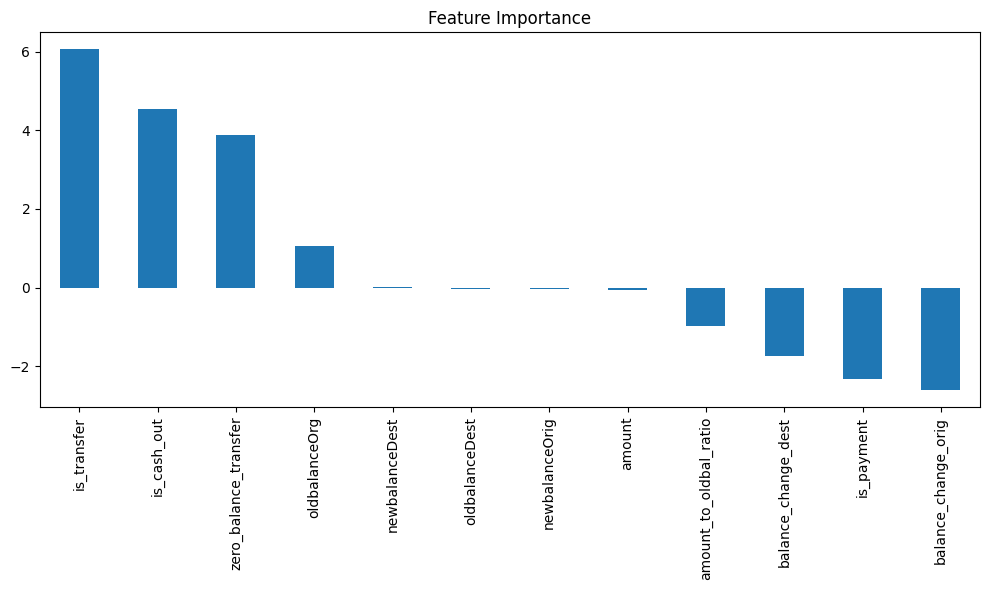

In [68]:
from sklearn.preprocessing import RobustScaler
def calculate_transaction_patterns(X):
    """Calculate transaction patterns and risk indicators"""
    patterns = X.copy()
    
    # Calculate balance changes (fixed column names)
    patterns['balance_change_orig'] = patterns['newbalanceOrig'] - patterns['oldbalanceOrg']
    patterns['balance_change_dest'] = patterns['newbalanceDest'] - patterns['oldbalanceDest']
    
    # Calculate transaction to balance ratios
    patterns['amount_to_oldbal_ratio'] = np.where(
        patterns['oldbalanceOrg'] > 0,
        patterns['amount'] / patterns['oldbalanceOrg'],
        999  # High value for zero balance
    )
    
    # Flag suspicious patterns
    patterns['zero_balance_transfer'] = ((patterns['oldbalanceOrg'] == 0) & 
                                       (patterns['newbalanceOrig'] == 0)).astype(int)
    
    # Transaction type encoding
    patterns['is_transfer'] = (patterns['type'] == 'TRANSFER').astype(int)
    patterns['is_cash_out'] = (patterns['type'] == 'CASH_OUT').astype(int)
    patterns['is_payment'] = (patterns['type'] == 'PAYMENT').astype(int)
    
    return patterns[['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                    'oldbalanceDest', 'newbalanceDest',
                    'balance_change_orig', 'balance_change_dest',
                    'amount_to_oldbal_ratio', 'zero_balance_transfer',
                    'is_transfer', 'is_cash_out', 'is_payment']]

# Custom metric that combines precision and recall with higher weight on recall
def weighted_f1_score(y_true, y_pred, beta=2):
    """Calculate F-beta score with higher weight on recall"""
    from sklearn.metrics import fbeta_score
    return fbeta_score(y_true, y_pred, beta=beta)

# Start MLflow run
with mlflow.start_run(run_name="custom_fraud_detection_experiment") as run:
    # Feature engineering
    feature_engineering = FunctionTransformer(calculate_transaction_patterns)
    
    # Define all features
    all_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                   'oldbalanceDest', 'newbalanceDest',
                   'balance_change_orig', 'balance_change_dest',
                   'amount_to_oldbal_ratio', 'zero_balance_transfer',
                   'is_transfer', 'is_cash_out', 'is_payment']
    
    # Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('scaler', RobustScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, all_features)
        ],
        remainder='drop'
    )
    
    # Create full pipeline
    model = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    # Split data
    X = df.drop('isFraud', axis=1)
    y = df['isFraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    standard_f1 = f1_score(y_test, y_pred)
    weighted_f1 = weighted_f1_score(y_test, y_pred, beta=2)
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("feature_engineering", "transaction_patterns")
    mlflow.log_param("scaler", "RobustScaler")
    
    # Log metrics
    mlflow.log_metric("standard_f1", standard_f1)
    mlflow.log_metric("weighted_f1", weighted_f1)
    
    # Log feature importance
    coef_df = pd.DataFrame(
        model.named_steps['classifier'].coef_[0],
        index=all_features,
        columns=['coefficient']
    ).sort_values('coefficient', ascending=False)
    
    # Save feature importance plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    coef_df['coefficient'].plot(kind='bar')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    # Log the feature importance plot
    mlflow.log_artifact('feature_importance.png')
    
    # Log the model
    signature = infer_signature(X_train, y_pred)
    mlflow.sklearn.log_model(model, "fraud_detection_model", signature=signature)
    
    # Print results
    print(f"Standard F1 Score: {standard_f1:.3f}")
    print(f"Weighted F1 Score (β=2): {weighted_f1:.3f}")
    print("\nTop 5 Most Important Features:")
    print(coef_df.head())

In [45]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class AdvancedFraudFeatures(BaseEstimator, TransformerMixin):
    """Custom transformer for advanced fraud detection features"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = X.copy()
        
        # Advanced transaction patterns
        features['transaction_velocity'] = features['amount'] / (features['oldbalanceOrg'] + features['oldbalanceDest'] + 1)
        features['balance_drain_ratio'] = np.where(
            features['oldbalanceOrg'] > 0,
            (features['oldbalanceOrg'] - features['newbalanceOrig']) / features['oldbalanceOrg'],
            1
        )
        
        # Suspicious patterns
        features['complete_drain'] = ((features['oldbalanceOrg'] > 0) & 
                                    (features['newbalanceOrig'] == 0)).astype(int)
        features['large_transfer'] = (features['amount'] > features['oldbalanceOrg'] * 0.9).astype(int)
        
        # Destination account patterns
        features['dest_balance_increase'] = (features['newbalanceDest'] > 
                                           features['oldbalanceDest'] * 1.5).astype(int)
        
        return features

# Start MLflow run
with mlflow.start_run(run_name="advanced_fraud_detection_v5") as run:
    # Define feature columns
    numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest']
    categorical_features = ['type']
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )
    
    # Create model pipeline
    model = Pipeline([
        ('feature_engineering', AdvancedFraudFeatures()),
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            random_state=42
        ))
    ])
    
    # Split data
    X = data.drop('isFraud', axis=1)
    y = data['isFraud']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    # Log parameters and metrics
    mlflow.log_params({
        "model_type": "GradientBoostingClassifier",
        "n_estimators": 200,
        "learning_rate": 0.1,
        "max_depth": 5,
        "subsample": 0.8
    })
    
    mlflow.log_metrics({
        "f1_score": f1,
        "pr_auc": pr_auc
    })
    
    # Create and log PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('pr_curve.png')
    mlflow.log_artifact('pr_curve.png')
    plt.close()
    
    # Get feature names after pipeline transformation
    # First, get the feature names from custom transformer
    engineered_feature_names = [
        'transaction_velocity', 'balance_drain_ratio', 
        'complete_drain', 'large_transfer', 
        'dest_balance_increase'
    ]
    
    # Get categorical feature names
    categorical_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
    categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features).tolist()
    
    # Combine all feature names in the correct order
    final_feature_names = numeric_features + engineered_feature_names + categorical_feature_names
    
    # Get feature importances
    importances = model.named_steps['classifier'].feature_importances_
    
    # Debug print
    print(f"Number of feature names: {len(final_feature_names)}")
    print(f"Number of importance values: {len(importances)}")
    print("Feature names:", final_feature_names)
    
    # Create feature importance dataframe only if lengths match
    if len(final_feature_names) == len(importances):
        importance_df = pd.DataFrame({
            'feature': final_feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Create and log feature importance plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importance_df)), importance_df['importance'])
        plt.xticks(range(len(importance_df)), importance_df['feature'], rotation=45, ha='right')
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        mlflow.log_artifact('feature_importance.png')
        plt.close()
        
        # Print results
        print(f"\nF1 Score: {f1:.3f}")
        print(f"PR AUC Score: {pr_auc:.3f}")
        print("\nTop 5 Most Important Features:")
        print(importance_df.head())
    else:
        print("\nError: Number of features doesn't match number of importance values")
        print("Skipping feature importance visualization")
    
    # Log the model
    mlflow.sklearn.log_model(model, "custom_experiment2")

🏃 View run advanced_fraud_detection_v5 at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3/runs/526bc986e29244c5b00b82dd112aac9c
🧪 View experiment at: https://dagshub.com/charankonduru2003/fraud_detection.mlflow/#/experiments/3


AttributeError: 'list' object has no attribute 'drop'

## F1 scores plot

In [46]:
import mlflow
import mlflow.tracking
import pandas as pd
import matplotlib.pyplot as plt

client = mlflow.tracking.MlflowClient()

experiments = client.search_experiments()
runs = []

# Collect run data from all experiments
for exp in experiments:
    experiment_id = exp.experiment_id
    runs += client.search_runs(experiment_id)

data = []
f1_score_keys = ['f1_score', 'train_f1_score', 'standard_f1']

# Extract F1 scores from different keys
for run in runs:
    for key in f1_score_keys:
        if key in run.data.metrics:
            data.append({
                'experiment_name': run.data.tags.get('mlflow.runName'),
                'f1_score': run.data.metrics[key],
                'f1_type': key  # To track which type of F1 was logged
            })
            
df = pd.DataFrame(data)


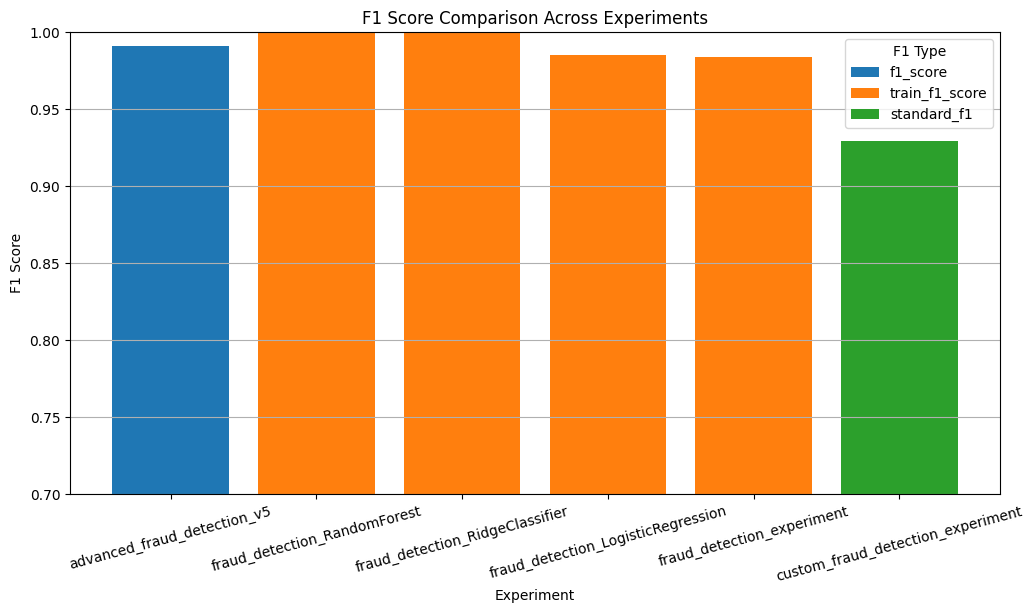

In [47]:
plt.figure(figsize=(12, 6))

# Plot each F1 type with a different color
for f1_type in df['f1_type'].unique():
    subset = df[df['f1_type'] == f1_type]
    plt.bar(subset['experiment_name'], subset['f1_score'], label=f1_type)

plt.xlabel('Experiment')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Experiments')
plt.xticks(rotation=15)
plt.ylim(0.7, 1)  # Adjust if necessary
plt.legend(title="F1 Type")
plt.grid(axis='y')
plt.show()

